In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from astropy import cosmology
import pyfftw

import make_universe_3D

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import time

In [2]:
rc("font", **{"family": "serif", "serif": ["times new roman"], "size": 15})
rc("text", usetex=True)
rc("axes", linewidth=1.5)

In [3]:
cos = cosmology.Planck18

In [6]:
def flat_ps(k, amp=10e-3):
    """
    Generate a flat power spectrum of amplitude amp.

    Parameters
    ----------
        k: float or array of flats
            Fourier mode in Mpc-1.
        amp: float
            Desired amplitude for the PS, in K2.

    """
    k = np.atleast_1d(k)
    return amp * np.ones(k.shape)

In [7]:
#make a lil universe
uni_3d = make_universe_3D.universe(
    flat_ps,
    1024,
    1024,
    150, 
    200.,
    200.,
    250.,
    z_mid=8.5,
    verbose=False)
uni = uni_3d.make_universe()

mean -8.754932542820448e-20


## Test speed of 3D FFT depending on number of cells

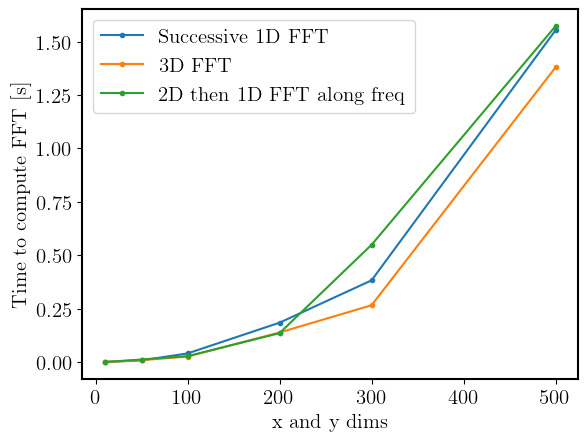

In [8]:
dims = np.array([10, 50, 100, 200, 300, 500])
times1, times2, times3 = np.zeros(dims.size), np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):

    cube = uni[:nn, :nn, :]
    test1 = np.array(cube, dtype=complex)
    t0 = time.perf_counter()
    for i in range(cube.ndim):
        test1[...] = np.fft.fft(test1, axis=i)
    t1 = time.perf_counter()
    times1[u] = t1-t0

    cube = uni[:nn, :nn, :]
    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2[u] = t1-t0

    t0 = time.perf_counter()
    test3 = np.fft.fft2(cube, axes=(0, 1))
    test4 = np.fft.fft(test3, axis=2)
    t1 = time.perf_counter()
    times3[u] = t1-t0

plt.figure()
plt.plot(dims, times1, label='Successive 1D FFT', marker='.')
plt.plot(dims, times2, label='3D FFT', marker='.')
plt.plot(dims, times3, label='2D then 1D FFT along freq', marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute FFT [s]')
plt.legend()

In [9]:

# what if number of cells is power of two
dims_pow2 = np.array([2**i for i in np.arange(4, 10)])
times1_pow2, times2_pow2, times3_pow2 = np.zeros(dims.size), np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):

    cube = uni[:nn, :nn, :]
    test1 = np.array(cube, dtype=complex)
    t0 = time.perf_counter()
    for i in range(cube.ndim):
        test1[...] = np.fft.fft(test1, axis=i)
    t1 = time.perf_counter()
    times1_pow2[u] = t1-t0

    cube = uni[:nn, :nn, :]
    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2_pow2[u] = t1-t0

    t0 = time.perf_counter()
    test3 = np.fft.fft2(cube, axes=(0, 1))
    test4 = np.fft.fft(test3, axis=2)
    t1 = time.perf_counter()
    times3_pow2[u] = t1-t0

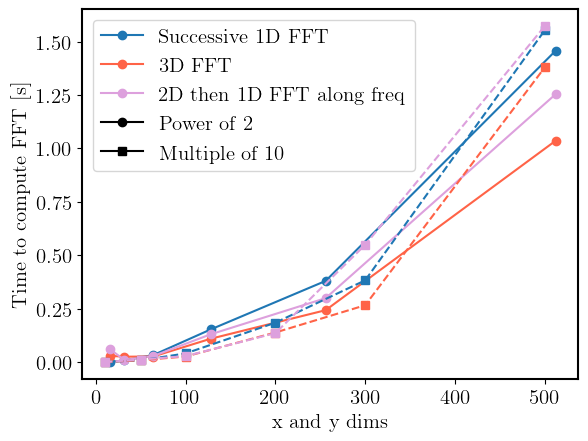

In [10]:
plt.figure()
plt.plot(dims_pow2, times1_pow2, label='Successive 1D FFT', marker='o', color='C0')
plt.plot(dims_pow2, times2_pow2, label='3D FFT', marker='o', color='tomato')
plt.plot(dims_pow2, times3_pow2, label='2D then 1D FFT along freq', marker='o', color='plum')
plt.plot(dims, times1, marker='s', color='C0', ls='--')
plt.plot(dims, times2, marker='s', color='tomato', ls='--')
plt.plot(dims, times3, marker='s', color='plum', ls='--')
plt.plot([], [], marker='o', color='k', label='Power of 2')
plt.plot([], [], marker='s', color='k', label='Multiple of 10')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute FFT [s]')
plt.legend()

In [11]:
# Now in one dimension
for array_length in (2**22, (2**22)-1):
    total_time = 0

    # Do the FFT 10 times, to allow for some random error
    for i in range(10):
        in_array = np.random.rand(array_length)
        start = time.perf_counter()
        out_array = np.fft.fft(in_array)
        total_time += time.perf_counter() - start

    print("array_length:", array_length,
          "total_time:", total_time)

array_length: 4194304 total_time: 1.0782269149998456
array_length: 4194303 total_time: 7.583532124999806


## Compare FFT to rFFT

In [12]:
array_length = 2**22

total_time = 0
in_array = np.random.rand(array_length)
start = time.perf_counter()
out_array = np.fft.fft(in_array)
total_time += time.perf_counter() - start

print("fft:", array_length,
        "total_time:", total_time)

total_time = 0
in_array = np.random.rand(array_length)
start = time.perf_counter()
out_array = np.fft.rfft(in_array)
total_time += time.perf_counter() - start

print("rfft:", array_length,
        "total_time:", total_time)
print(in_array.shape, out_array.shape)

fft: 4194304 total_time: 0.08555712499992296
rfft: 4194304 total_time: 0.062328374999992775
(4194304,) (2097153,)


## Compare different FFT algorithms

In [15]:
def np_rfft(*args):
    return np.fft.rfft(*args)

def interfaces_rfft(*args):
    return pyfftw.interfaces.numpy_fft.rfft(*args)

# Use our wrapper functions else function names will be "rfft" for both
for fft_func in (np_rfft, interfaces_rfft):

    for array_length in (2**22, (2**22)-1):
        total_time = 0

        for i in range(10):
            in_array = np.random.rand(array_length)
            start = time.perf_counter()
            out_array = fft_func(in_array)
            total_time += time.perf_counter() - start

        print("fft_func:", fft_func.__name__,
              "array_length:", array_length,
              "total_time:", total_time)

fft_func: np_rfft array_length: 4194304 total_time: 0.6111990420000666
fft_func: np_rfft array_length: 4194303 total_time: 3.9567755830000806
fft_func: interfaces_rfft array_length: 4194304 total_time: 1.2511644569998452
fft_func: interfaces_rfft array_length: 4194303 total_time: 2.7919726660002198


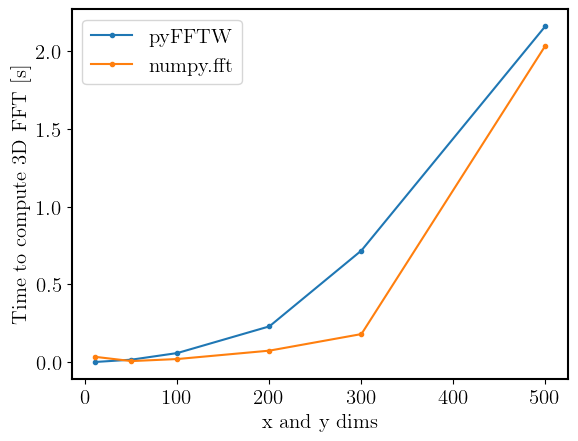

In [16]:
dims = np.array([10, 50, 100, 200, 300, 500])
times1, times2 = np.zeros(dims.size), np.zeros(dims.size)
for u, nn in enumerate(dims):
    cube = uni[:nn, :nn, :]

    t0 = time.perf_counter()
    test = pyfftw.interfaces.numpy_fft.fftn(cube)
    t1 = time.perf_counter()
    times1[u] = t1-t0

    t0 = time.perf_counter()
    test2 = np.fft.fftn(cube)
    t1 = time.perf_counter()
    times2[u] = t1-t0

plt.figure()
plt.plot(dims, times1, label='pyFFTW', marker='.')
plt.plot(dims, times2, label='numpy.fft', marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Time to compute 3D FFT [s]')
plt.legend()


Text(0, 0.5, 'Diff time w and w\\o FFT shift [s]')

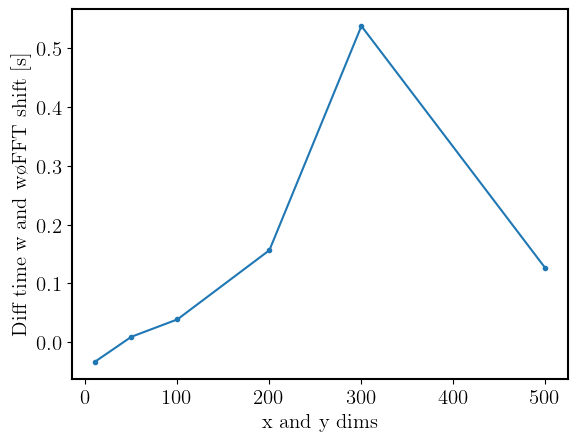

In [17]:
plt.figure()
plt.plot(dims, times1-times2, marker='.')
plt.xlabel('x and y dims')
plt.ylabel('Diff time w and w\o FFT shift [s]')